# Predicting Medical Expenses via Regression

## Introduction
This notebook will utilize regression analysis to predict the average medical expenses for a population found in a dataset. The dataset used ("insurance.csv") comes from the Brett Lantz book <u>Machine Learning with R, 2nd ed.</u> For this project I will be performing the analysis in Python instead of R.<br>
<b>The dataset contains 1338 observations and 6 features: age, sex, bmi, children(dependents), smoker, and region.</b>

<b>Dataset features:</b><br>
<b>expenses</b> - the cost of medical expenses (what I am looking to predict)<br>
<b>age</b> - age of the observation <br>
<b>sex</b> - gender of the observation <br>
<b>bmi</b> - body mass index, a measurement of a persons weight divided by their height. What is generally considered an ideal BMI is in the range between 18.5-24.9 with obesity considerd at BMI's of 30 and greater. (https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi-m.htm)<br>
<b>children</b> - number of children/dependents covered by the policy holder's insurance plan<br>
<b>smoker</b> - whether the policy holder is a smoker or not<br>
<b>region</b> - the policy holder's general geographic location in the US: northeast, southeast, northwest, southwest<br>


From reviewing the dataset, 3 of the features in particular: age, bmi, and smoker, stand out to me the most as features that may generally affect one's health and consequently medical expenses.<br> - As we grow older past middle age, we tend to require more medical attention and thus expenses tend to go up (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1361028/).<br> - BMI is like a quick way to generally categorize whether an individual is of a heathy weight or not accounting for their height. Having higher BMI levels has correlated to higher levels of body fat and thus the various metabolic diseases associated with body fattness.(https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.htmlt%20of%20%24266).<br> - Smoking has been shown countless times over the years to contribute to many diseases as well https://www.cdc.gov/tobacco/data_statistics/fact_sheets/health_effects/effects_cig_smoking/index.htm

### Imports

In [1]:
# Data manipulation
import csv
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.width = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
sns.set_style('white')

# Data Processing

In [2]:
file = "C:/Users/Jeff/Desktop/Projects/Data Science Portfolio/Regression Projects/insurance.csv"

df = pd.read_csv(file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 57.6+ KB


In [3]:
# pull a sample of the data to get a sense of it
df.sample(n=5, random_state = 42)

,age,sex,bmi,children,smoker,region,expenses
764,45,female,25.2,2,no,northeast,9095.07
887,36,female,30.0,0,no,northwest,5272.18
890,64,female,26.9,0,yes,northwest,29330.98
1293,46,male,25.7,3,no,northwest,9301.89
259,19,male,31.9,0,yes,northwest,33750.29


<b>"sex", "smoker", and "region" can all be changed to unordered categorical features</b>

In [4]:
# change features to categorical
cols_to_change = {'sex':'category','smoker':'category','region':'category'}
df = df.astype(cols_to_change) 
#df.info()

# EDA

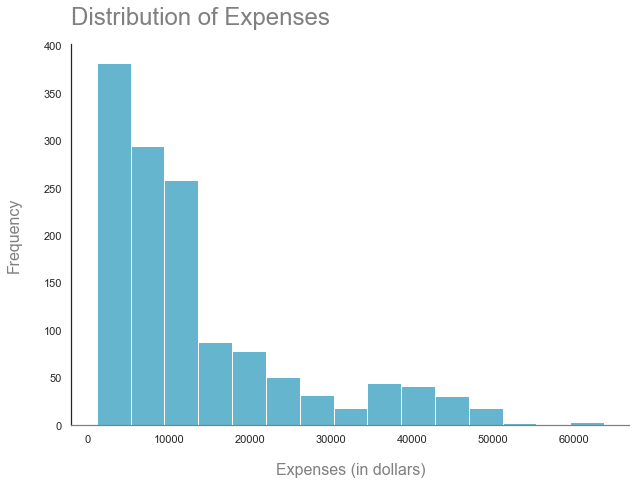

In [5]:
# univariate distribution of 'expenses'
def histogram(data,outcome):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #plt.rc_context({'axes.edgecolor':'0.5', 'xtick.color':'0.5', 'ytick.color':'0.5'})
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    df[outcome].plot(kind='hist',bins = 15, color='c', figsize=(10,7))
    plt.title('Distribution of Expenses', size=24, loc = 'left',pad = 20, color = 'gray')
    plt.xlabel('\nExpenses (in dollars)', size=16,labelpad = 0, color = 'gray')
    plt.ylabel('Frequency\n', size=16, color = 'gray')
    sns.despine()

histogram(df,'expenses')   

<b>The 'expenses' feature has a considerable right-skewed tail which will need to be adjusted before the modeling process to help with getting a better fit. Most of the observations in the dataset have expenses of $15000 or less. 

In [6]:
# inspecting all the numerical features
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


<b> Above:  the medians and means for 'age', 'bmi', and 'children' are similar which indicates that there is a symetrical distribution with those features. We can again see that 'expenses' has a right skew as the mean is considerably larger than the median.</b>

In [7]:
# also inspec the categorical data
cat_cols = ['sex','smoker','region']
for c in cat_cols:
    df[c].value_counts()

male      676
female    662
Name: sex, dtype: int64

no     1064
yes     274
Name: smoker, dtype: int64

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

<b>Both 'sex' and 'region' have approximately even divisions among their categories and there are far more non-smokers than smokers.</b>

Now I will take a look at whether there are correlations between the numerical data.

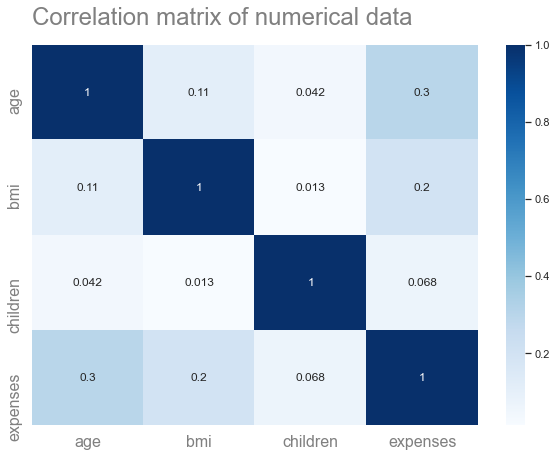

In [8]:
def heatmap(data):    
    plt.figure(figsize=(10,7))
    plt.rcParams['font.size'] = 12
    plt.title('Correlation matrix of numerical data', size=24, loc = 'left',pad = 20, color = 'gray')
    corrMatrix = data.corr()
    res = sns.heatmap(corrMatrix,cmap = 'Blues', annot=True)
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 16, color = 'gray')
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 16, color = 'gray')
    
heatmap(df)

<b>While the correlation between 'expenses' and the other features are on the weaker positive side, this still implies that as 'age', 'bmi', and 'children' increase, so do medical expenses. To get a better sense of these associations visually, we can look at a scatterplot matrix. I will also introduce a categorical variable as colors to see whether there are any added observable trends in the data or not.

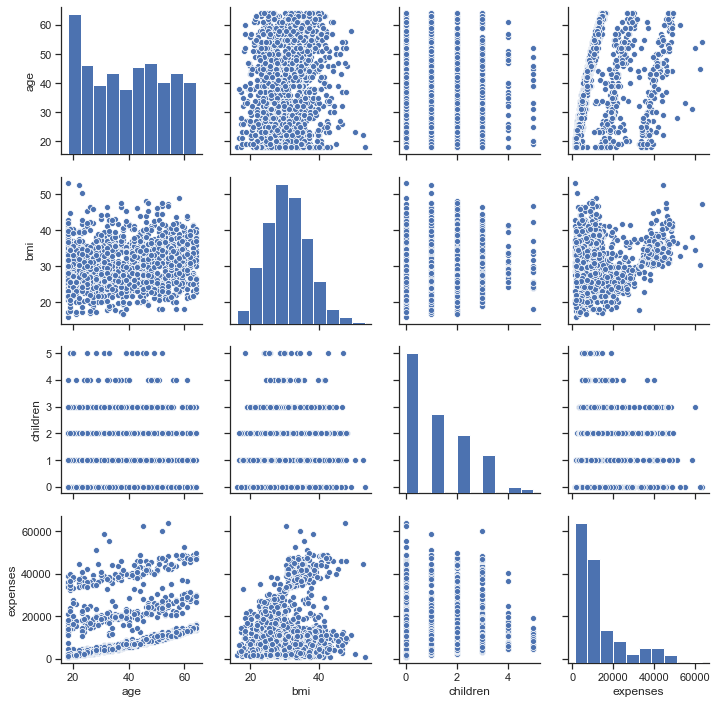

In [9]:
sns.set(style="ticks")
sns.pairplot(df)

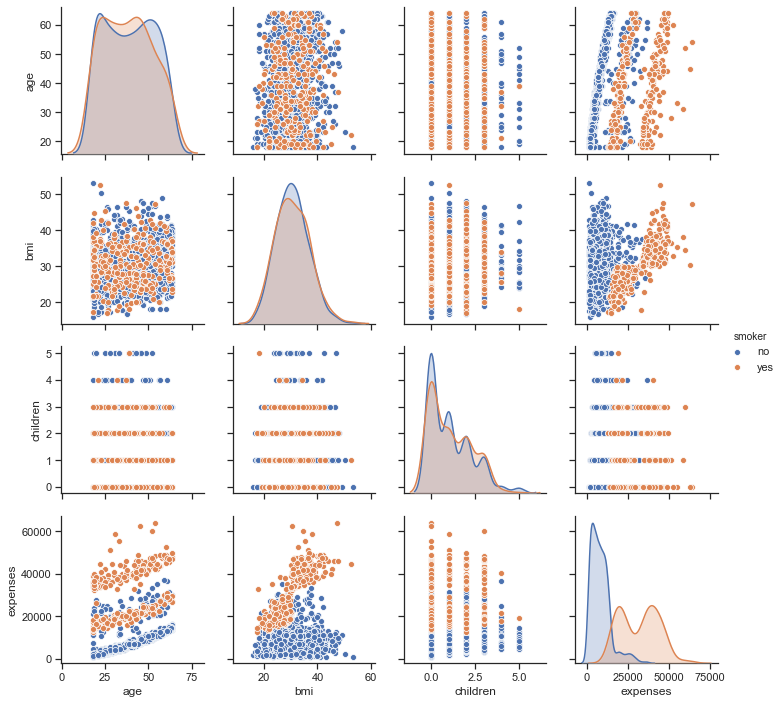

In [10]:
sns.set(style="ticks")
sns.pairplot(df,hue = 'smoker')

<b> The correlation matrix above is looking at the correlations between the numerical data with the added feature of whether the observation is a smoker (orange) or non-smoker (blue). The observations of smokers tend to have higher expenses which is notable when looking at the plots for expenses and age, as well as expenses and bmi. The univariate distribution for expenses (bottom right corner) is particulary useful in demonstrating that the differences in expenses between those who smoke and those who do not.</b>
    
<b>This may indicate that I need to create an interaction feature between smoking and bmi.</b> 

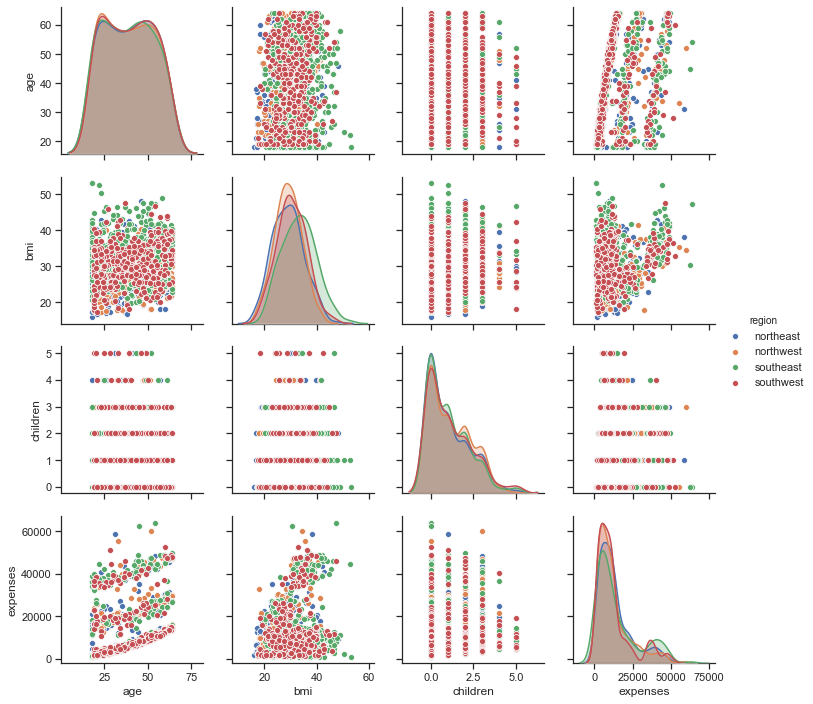

In [11]:
sns.set(style="ticks")
sns.pairplot(df,hue = 'region')

<b> In the correlation matrix above, when looking at the correlations by region, the bmi distribution for the southeast is slightly higher than the other regions. Otherwise, the regions appear relatively similar.</b> 

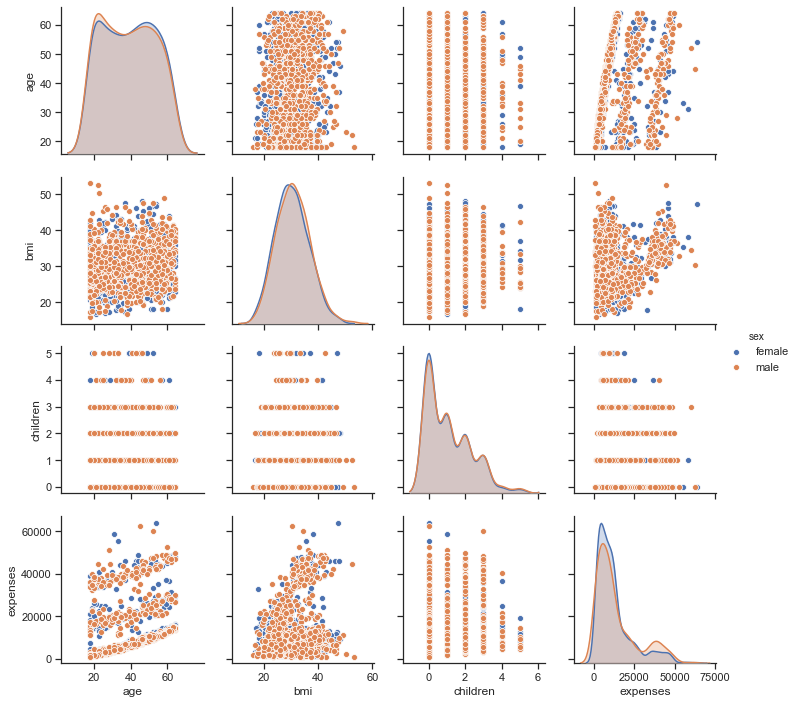

In [12]:
sns.set(style="ticks")
sns.pairplot(df,hue = 'sex')

<b> Sex does not seem to have a visually discernable effect on expenses</b>

# Analysis/Modeling
Here I will begin the modeling process using the Statsmodels package

## Model 1

In [13]:
# set my predictors / outcome
predictors = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
outcome = 'expenses'

# get one hot encoding of the categorical variables 
X = pd.get_dummies(df[predictors], drop_first = True)

# modeling using the statsmodels API
model1 = sm.OLS(df[outcome],X.assign(const=1))
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.9
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:32:02   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                256.8392     11.899  

<b>From the output, the Adjusted R^2 is 0.749 which is a good sign that our model is explaining nearly 75% of the variation of our predictor variable</b>

In [14]:
# reviewing the Errors
print(f'Mean Squared Error (MSE): {(mse(df[outcome],results1.predict()))}')
print(f'Root Mean Squared Error (RMSE): {(rmse(df[outcome],results1.predict()))}')   

Mean Squared Error (MSE): 36499631.63514606
Root Mean Squared Error (RMSE): 6041.49250062814


In [15]:
#this is usefull to look at prediction errors
results1.resid.round().describe()

count     1338.000000
mean        -0.001495
std       6043.749245
min     -11303.000000
25%      -2850.500000
50%       -979.500000
75%       1384.000000
max      29982.000000
dtype: float64

<b>Looking at the residuals, we see that the model under predicted expenses by nearly \\$30,000 for one observation. From the 25% and 75%, we see that the majority of the errors fall between \\$2850 over and \\$1383 under the true value.</b>

<b> Next I will try and work on improving the model through adding some different variables.
1. add a quadradtic variable for age and bmi
2. add a transformed variable that accounts for healthy (<30) and unheathy BMI(>30)
3. add an interaction variable that inspects the interaction between smoking and BMI
</b>

## Model 2

In [16]:
# age may not have a linear relationship with expenses. As individuals get older, expenses may track at an increasing rate

# creating a new quadratic feature to test for 'age'
df['age2'] = df['age']**2

In [17]:
# create the new model
# set my predictors / outcome
predictors2 = ['age', 'age2', 'sex', 'bmi', 'children', 'smoker', 'region']
outcome2 = 'expenses'

# get one hot encoding of the categorical variables 
X = pd.get_dummies(df[predictors2], drop_first = True)

model2 = sm.OLS(df[outcome2],X.assign(const=1))
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     451.6
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:32:03   Log-Likelihood:                -13540.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1328   BIC:                         2.715e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                -54.4226     80.989  

In [18]:
# reviewing the Errors
print(f'orig Mean Squared Error (MSE): {(mse(df[outcome2],results2.predict()))}')
print(f'orig Root Mean Squared Error (RMSE): {(rmse(df[outcome2],results2.predict()))}')  

#this is usefull to look at prediction errors
results2.resid.round().describe()

orig Mean Squared Error (MSE): 36089467.31861016
orig Root Mean Squared Error (RMSE): 6007.450983454643


count     1338.000000
mean        -0.006726
std       6009.688310
min     -11666.000000
25%      -2855.000000
50%       -942.500000
75%       1300.750000
max      30815.000000
dtype: float64

<b> Model 2 does not seem to improve upon Model 1 very much (adj.R2 of 0.752 vs 0.749).

## Model 3

In [19]:
# we can look to see if a BMI's effect is cumulative or whether an effect is seen when it is greater than 30 (obese) 
df['bmi30'] = np.where(df['bmi']>30,1,0)

In [20]:
# create the new model
# set my predictors / outcome
predictors3 = ['age','age2', 'sex', 'bmi', 'bmi30', 'children', 'smoker', 'region']
outcome3 = 'expenses'

# get one hot encoding of the categorical variables 
X = pd.get_dummies(df[predictors3], drop_first = True)

model3 = sm.OLS(df[outcome3],X.assign(const=1))
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     416.0
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:32:03   Log-Likelihood:                -13528.
No. Observations:                1338   AIC:                         2.708e+04
Df Residuals:                    1327   BIC:                         2.714e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                -28.4842     80.458  

In [21]:
# reviewing the Errors
print(f'Mean Squared Error (MSE): {(mse(df[outcome3],results3.predict()))}')
print(f'Root Mean Squared Error (RMSE): {(rmse(df[outcome3],results3.predict()))}')   

#this is usefull to look at prediction errors
results3.resid.round().describe()

Mean Squared Error (MSE): 35438957.57814378
Root Mean Squared Error (RMSE): 5953.062873693153


count     1338.000000
mean         0.009716
std       5955.286270
min     -12497.000000
25%      -3369.000000
50%        108.000000
75%       1300.000000
max      29283.000000
dtype: float64

<b> Model 3 does not seem to improve upon Model 1 very much (adj.R2 of 0.756 vs 0.749). 'smoker_yes' continues to be a strong predictor for medical expenses.

## Model 4

In [22]:
# create the new model. I will include an interaction variable between bmi30 and smoking
# set my predictors / outcome
# we will use 'from_formula' option to include the interaction variable between bmi30 and smoking

formula = 'expenses ~ age + age2 + sex + bmi + bmi30 + children + smoker + region + bmi30*smoker'
model4 = sm.OLS.from_formula(formula, data = df)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     784.3
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:32:03   Log-Likelihood:                -13129.
No. Observations:                1338   AIC:                         2.628e+04
Df Residuals:                    1326   BIC:                         2.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              86.2658   1

In [23]:
# reviewing the Errors
print(f'Mean Squared Error (MSE): {(mse(df[outcome],results4.predict()))}')
print(f'Root Mean Squared Error (RMSE): {(rmse(df[outcome],results4.predict()))}')   

#this is usefull to look at prediction errors
results4.resid.round().describe()

Mean Squared Error (MSE): 19521858.034346987
Root Mean Squared Error (RMSE): 4418.354675028589


count     1338.000000
mean        -0.012706
std       4419.995754
min      -4346.000000
25%      -1658.750000
50%      -1263.000000
75%       -754.250000
max      24204.000000
dtype: float64

In [24]:
results4.params

Intercept                 86.265797
sex[T.male]             -513.669276
smoker[T.yes]          13541.152038
region[T.northwest]     -224.128712
region[T.southeast]     -848.156153
region[T.southwest]    -1162.819686
age                      -31.830254
age2                       3.706300
bmi                      122.469228
bmi30                  -1030.723274
bmi30:smoker[T.yes]    19837.297804
children                 657.491722
dtype: float64

<b> Model 4 gives a low RMSE and the highest adj.R2 so far at 0.866. For a smoker, their annual expenses are increased by \\$13541 and the interaction effect between 'bmi30' and 'smoker' adds another \\$19837 to the annual expenses of someone who smokes and is obese (bmi greater than 30)

## Model 5

In [25]:
# check on whether 'bmi' as a quadradic better predicts expenses than 'bmi30'
# bmi may not have a linear relationship with expenses. As an individual's BMI increases, expenses may track at an increasing rate

# creating a new quadratic feature to test for 'bmi'
df['bmi2'] = df['bmi']**2

In [26]:
# create the new model. I will include an interaction variable between bmi2 and smoking
# set my predictors / outcome
# we will use 'from_formula' option to include the interaction variable between bmi30 and smoking

formula = 'expenses ~ age + age2 + sex + bmi + bmi2 + children + smoker + region + bmi2*smoker'
model5 = sm.OLS.from_formula(formula, data = df)
results5 = model5.fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     638.3
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:32:04   Log-Likelihood:                -13247.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1326   BIC:                         2.658e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.051e+04   2

In [27]:
# reviewing the Errors
print(f'Mean Squared Error (MSE): {(mse(df[outcome],results5.predict()))}')
print(f'Root Mean Squared Error (RMSE): {(rmse(df[outcome],results5.predict()))}')   

#this is usefull to look at prediction errors
results5.resid.round().describe()

Mean Squared Error (MSE): 23278732.50709289
Root Mean Squared Error (RMSE): 4824.80388275968


count     1338.000000
mean         0.000747
std       4826.599792
min     -17501.000000
25%      -1854.750000
50%      -1471.500000
75%       -390.500000
max      31548.000000
dtype: float64

<b>It appears that while the bmi feature as a quadradic performs better than the bmi feature from model 1, it fails to explain the variation as well as the 'bmi30' feature. Model 4 has a slightly better adj.R2 (.866 v .84) and smaller RMSE (4418 v 4824).</b>

# Conclusion

Model 4 will be the chosen model to use for predicting our medical expenses. By transforming age into a quadratic ('age2') and converting bmi to a boolean with 'bmi30' I was able to better fit the data. The interaction variable between 'bmi30' and 'smoker' also enhanced the accuracy of predicting medical expenses. 

<b>Results Model 1:</b> <br>
RMSE: 6041<br> 
adj.R2: .75<br>
<b>Results Model 4:</b> <br>
RMSE: 4418<br>
adj.R2: .87 <br>

Both 'smoking' and 'bmi30:smoker' showed strong statistical significance and very high t stataistics. This supports my earlier notion about the effect after observing the correlation matrix that overlaid the 'smoker' feature upon the correaltions. What is most notable is that the effect from the interaction between 'bmi30' and 'smoker' is an added \\$19837 increase in expenses. This indicates that having a high bmi (greater than 30) and being a smoker contributes to much higher medical expenses. 